# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

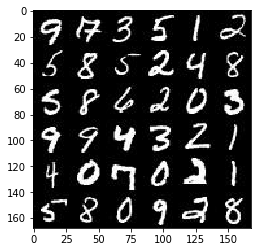

In [3]:
show_n_images = 42

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# !pip install -U matplotlib==2.0.2
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

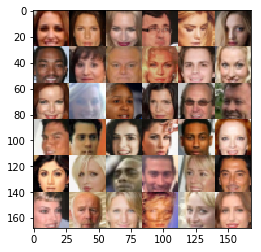

In [4]:
show_n_images = 42

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(dtype=tf.float32,shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [24]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    dropout = 0.5
    with tf.variable_scope('discriminator', reuse=reuse):
        weights = tf.contrib.layers.xavier_initializer_conv2d()
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer = weights)
        x1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.layers.dropout(x1, dropout)
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        drop2 = tf.layers.dropout(x2, dropout)
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        drop3 = tf.layers.dropout(x3, dropout)

        flat = tf.reshape(drop3, (-1, 4*4*256))
        # dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    dropout = 0.5
    with tf.variable_scope('generator', reuse= not is_train):
        weights = tf.contrib.layers.xavier_initializer_conv2d()
        x1 = tf.layers.dense(z, 3*3*512, use_bias=False, activation=None)
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.layers.dropout(x1, dropout, training=is_train)
        
        x2 = tf.layers.conv2d_transpose(drop1, 256, kernel_size=4, strides=2, padding='same', 
                                        use_bias=False, activation=None, kernel_initializer = weights)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        drop2 = tf.layers.dropout(x2, dropout, training=is_train)
   
        x3 = tf.layers.conv2d_transpose(drop2, 128, kernel_size=4, strides=2, padding='valid', 
                                        use_bias=False, activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        drop3 = tf.layers.dropout(x3, dropout, training=is_train)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(drop3, out_channel_dim, kernel_size=5,strides=2, padding='same', 
                                            activation=None)
        out = tf.tanh(logits)
        
    return out
    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    images_to_show = 9
    losses =[]
    steps = 0
    _, width, height, channels = data_shape
    
    real_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print("Trainning start ...")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Get images, reshape and rescale to pass to D
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Step: {}:".format(steps),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
                    
    print("Training done!")


                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Trainning start ...
Step: 10: Epoch 1/2... Discriminator Loss: 0.4662... Generator Loss: 3.4129
Step: 20: Epoch 1/2... Discriminator Loss: 2.0484... Generator Loss: 7.2741
Step: 30: Epoch 1/2... Discriminator Loss: 0.5610... Generator Loss: 3.6110
Step: 40: Epoch 1/2... Discriminator Loss: 0.5726... Generator Loss: 1.9812
Step: 50: Epoch 1/2... Discriminator Loss: 0.6714... Generator Loss: 1.4260
Step: 60: Epoch 1/2... Discriminator Loss: 0.3982... Generator Loss: 3.3118
Step: 70: Epoch 1/2... Discriminator Loss: 0.6160... Generator Loss: 1.4687
Step: 80: Epoch 1/2... Discriminator Loss: 0.4560... Generator Loss: 2.8794
Step: 90: Epoch 1/2... Discriminator Loss: 0.4106... Generator Loss: 3.0361
Step: 100: Epoch 1/2... Discriminator Loss: 0.7371... Generator Loss: 1.7749


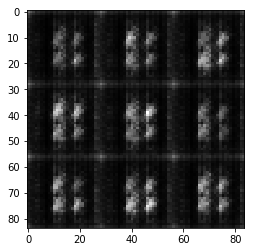

Step: 110: Epoch 1/2... Discriminator Loss: 0.4036... Generator Loss: 3.4273
Step: 120: Epoch 1/2... Discriminator Loss: 0.3780... Generator Loss: 4.3545
Step: 130: Epoch 1/2... Discriminator Loss: 0.3868... Generator Loss: 3.6625
Step: 140: Epoch 1/2... Discriminator Loss: 0.3931... Generator Loss: 4.9188
Step: 150: Epoch 1/2... Discriminator Loss: 0.4280... Generator Loss: 4.0989
Step: 160: Epoch 1/2... Discriminator Loss: 1.8632... Generator Loss: 0.5358
Step: 170: Epoch 1/2... Discriminator Loss: 0.4571... Generator Loss: 3.8139
Step: 180: Epoch 1/2... Discriminator Loss: 0.4210... Generator Loss: 2.9660
Step: 190: Epoch 1/2... Discriminator Loss: 0.4734... Generator Loss: 3.2129
Step: 200: Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 1.5190


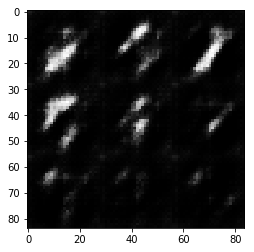

Step: 210: Epoch 1/2... Discriminator Loss: 0.7969... Generator Loss: 1.1672
Step: 220: Epoch 1/2... Discriminator Loss: 0.5583... Generator Loss: 2.4675
Step: 230: Epoch 1/2... Discriminator Loss: 0.4844... Generator Loss: 3.1097
Step: 240: Epoch 1/2... Discriminator Loss: 0.4702... Generator Loss: 2.8874
Step: 250: Epoch 1/2... Discriminator Loss: 0.4341... Generator Loss: 3.4603
Step: 260: Epoch 1/2... Discriminator Loss: 0.4607... Generator Loss: 3.2775
Step: 270: Epoch 1/2... Discriminator Loss: 1.1998... Generator Loss: 5.8441
Step: 280: Epoch 1/2... Discriminator Loss: 0.6472... Generator Loss: 1.6795
Step: 290: Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 1.2601
Step: 300: Epoch 1/2... Discriminator Loss: 0.5803... Generator Loss: 3.6708


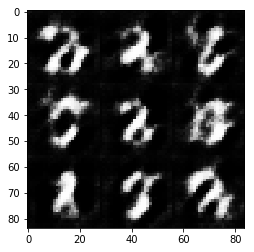

Step: 310: Epoch 1/2... Discriminator Loss: 0.4593... Generator Loss: 2.9719
Step: 320: Epoch 1/2... Discriminator Loss: 0.7262... Generator Loss: 3.2410
Step: 330: Epoch 1/2... Discriminator Loss: 0.5037... Generator Loss: 2.6737
Step: 340: Epoch 1/2... Discriminator Loss: 0.7398... Generator Loss: 1.5991
Step: 350: Epoch 1/2... Discriminator Loss: 0.8721... Generator Loss: 1.0176
Step: 360: Epoch 1/2... Discriminator Loss: 0.5439... Generator Loss: 2.6795
Step: 370: Epoch 1/2... Discriminator Loss: 0.9719... Generator Loss: 1.0803
Step: 380: Epoch 1/2... Discriminator Loss: 0.6025... Generator Loss: 2.9008
Step: 390: Epoch 1/2... Discriminator Loss: 0.4720... Generator Loss: 2.9222
Step: 400: Epoch 1/2... Discriminator Loss: 0.5329... Generator Loss: 2.3953


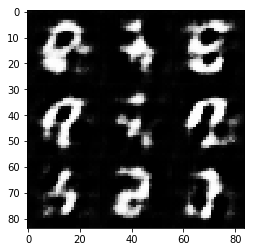

Step: 410: Epoch 1/2... Discriminator Loss: 0.5432... Generator Loss: 1.9867
Step: 420: Epoch 1/2... Discriminator Loss: 0.5531... Generator Loss: 3.5723
Step: 430: Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 4.2299
Step: 440: Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 4.1784
Step: 450: Epoch 1/2... Discriminator Loss: 0.6934... Generator Loss: 2.0822
Step: 460: Epoch 1/2... Discriminator Loss: 0.7563... Generator Loss: 1.6047
Step: 470: Epoch 1/2... Discriminator Loss: 1.1166... Generator Loss: 4.3120
Step: 480: Epoch 1/2... Discriminator Loss: 0.4994... Generator Loss: 2.0390
Step: 490: Epoch 1/2... Discriminator Loss: 0.7444... Generator Loss: 1.2822
Step: 500: Epoch 1/2... Discriminator Loss: 0.4834... Generator Loss: 2.5203


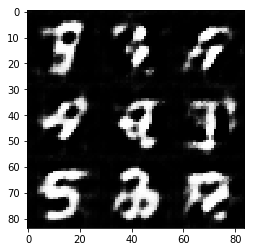

Step: 510: Epoch 1/2... Discriminator Loss: 0.5339... Generator Loss: 2.2939
Step: 520: Epoch 1/2... Discriminator Loss: 0.5337... Generator Loss: 2.2906
Step: 530: Epoch 1/2... Discriminator Loss: 0.5054... Generator Loss: 2.0319
Step: 540: Epoch 1/2... Discriminator Loss: 0.8366... Generator Loss: 4.0733
Step: 550: Epoch 1/2... Discriminator Loss: 0.9750... Generator Loss: 2.9580
Step: 560: Epoch 1/2... Discriminator Loss: 0.5846... Generator Loss: 2.0230
Step: 570: Epoch 1/2... Discriminator Loss: 0.4799... Generator Loss: 2.2767
Step: 580: Epoch 1/2... Discriminator Loss: 0.4610... Generator Loss: 3.1221
Step: 590: Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 1.5840
Step: 600: Epoch 1/2... Discriminator Loss: 0.5441... Generator Loss: 2.6447


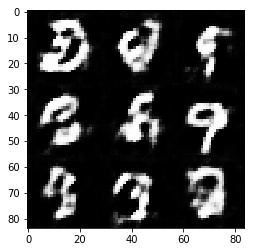

Step: 610: Epoch 1/2... Discriminator Loss: 0.5228... Generator Loss: 1.9625
Step: 620: Epoch 1/2... Discriminator Loss: 0.5568... Generator Loss: 3.7718
Step: 630: Epoch 1/2... Discriminator Loss: 0.4269... Generator Loss: 2.9722
Step: 640: Epoch 1/2... Discriminator Loss: 0.5496... Generator Loss: 2.0842
Step: 650: Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 1.5943
Step: 660: Epoch 1/2... Discriminator Loss: 0.4482... Generator Loss: 2.3955
Step: 670: Epoch 1/2... Discriminator Loss: 0.4899... Generator Loss: 3.0128
Step: 680: Epoch 1/2... Discriminator Loss: 0.4809... Generator Loss: 3.0116
Step: 690: Epoch 1/2... Discriminator Loss: 0.4794... Generator Loss: 2.7336
Step: 700: Epoch 1/2... Discriminator Loss: 0.4220... Generator Loss: 3.1074


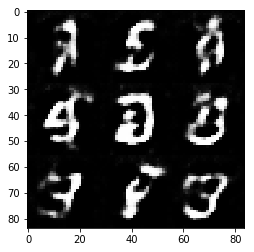

Step: 710: Epoch 1/2... Discriminator Loss: 0.6097... Generator Loss: 1.9381
Step: 720: Epoch 1/2... Discriminator Loss: 0.8041... Generator Loss: 1.7894
Step: 730: Epoch 1/2... Discriminator Loss: 0.4813... Generator Loss: 2.2900
Step: 740: Epoch 1/2... Discriminator Loss: 0.4255... Generator Loss: 3.3144
Step: 750: Epoch 1/2... Discriminator Loss: 0.3993... Generator Loss: 3.1417
Step: 760: Epoch 1/2... Discriminator Loss: 0.4321... Generator Loss: 2.6663
Step: 770: Epoch 1/2... Discriminator Loss: 0.3938... Generator Loss: 3.1570
Step: 780: Epoch 1/2... Discriminator Loss: 0.3903... Generator Loss: 3.2012
Step: 790: Epoch 1/2... Discriminator Loss: 0.4216... Generator Loss: 2.9727
Step: 800: Epoch 1/2... Discriminator Loss: 0.6499... Generator Loss: 5.0402


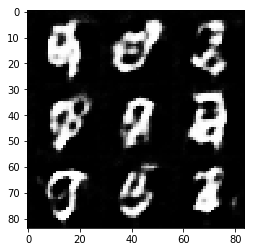

Step: 810: Epoch 1/2... Discriminator Loss: 0.6493... Generator Loss: 1.6590
Step: 820: Epoch 1/2... Discriminator Loss: 0.5275... Generator Loss: 2.1918
Step: 830: Epoch 1/2... Discriminator Loss: 0.7118... Generator Loss: 1.9174
Step: 840: Epoch 1/2... Discriminator Loss: 0.4215... Generator Loss: 3.0282
Step: 850: Epoch 1/2... Discriminator Loss: 0.5950... Generator Loss: 1.9071
Step: 860: Epoch 1/2... Discriminator Loss: 0.6070... Generator Loss: 2.4929
Step: 870: Epoch 1/2... Discriminator Loss: 0.4583... Generator Loss: 2.3852
Step: 880: Epoch 1/2... Discriminator Loss: 0.6311... Generator Loss: 2.1207
Step: 890: Epoch 1/2... Discriminator Loss: 0.4686... Generator Loss: 2.2859
Step: 900: Epoch 1/2... Discriminator Loss: 0.8002... Generator Loss: 1.3955


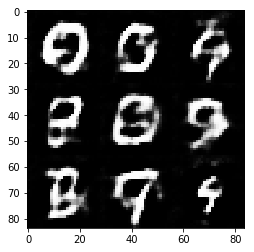

Step: 910: Epoch 1/2... Discriminator Loss: 0.4754... Generator Loss: 3.5396
Step: 920: Epoch 1/2... Discriminator Loss: 0.4358... Generator Loss: 2.3849
Step: 930: Epoch 1/2... Discriminator Loss: 0.4452... Generator Loss: 2.6594
Step: 940: Epoch 1/2... Discriminator Loss: 0.7446... Generator Loss: 1.6966
Step: 950: Epoch 1/2... Discriminator Loss: 0.3869... Generator Loss: 3.3500
Step: 960: Epoch 1/2... Discriminator Loss: 0.4151... Generator Loss: 3.3764
Step: 970: Epoch 1/2... Discriminator Loss: 0.5597... Generator Loss: 3.8029
Step: 980: Epoch 1/2... Discriminator Loss: 0.4075... Generator Loss: 3.4003
Step: 990: Epoch 1/2... Discriminator Loss: 0.3866... Generator Loss: 3.4971
Step: 1000: Epoch 1/2... Discriminator Loss: 0.6239... Generator Loss: 4.0342


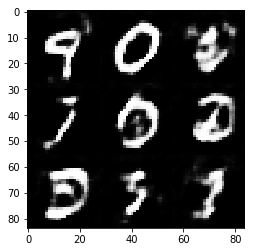

Step: 1010: Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 5.1692
Step: 1020: Epoch 1/2... Discriminator Loss: 0.5866... Generator Loss: 1.8119
Step: 1030: Epoch 1/2... Discriminator Loss: 0.6552... Generator Loss: 1.8237
Step: 1040: Epoch 1/2... Discriminator Loss: 0.5768... Generator Loss: 2.2346
Step: 1050: Epoch 1/2... Discriminator Loss: 0.4088... Generator Loss: 2.7476
Step: 1060: Epoch 1/2... Discriminator Loss: 1.3178... Generator Loss: 5.5716
Step: 1070: Epoch 1/2... Discriminator Loss: 0.4378... Generator Loss: 3.0790
Step: 1080: Epoch 1/2... Discriminator Loss: 0.4061... Generator Loss: 3.5165
Step: 1090: Epoch 1/2... Discriminator Loss: 0.4858... Generator Loss: 2.9234
Step: 1100: Epoch 1/2... Discriminator Loss: 0.6147... Generator Loss: 1.9939


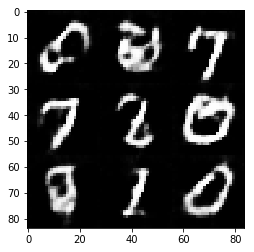

Step: 1110: Epoch 1/2... Discriminator Loss: 0.4395... Generator Loss: 3.1469
Step: 1120: Epoch 1/2... Discriminator Loss: 0.4478... Generator Loss: 2.9631
Step: 1130: Epoch 1/2... Discriminator Loss: 0.4594... Generator Loss: 3.6007
Step: 1140: Epoch 1/2... Discriminator Loss: 0.4179... Generator Loss: 3.5517
Step: 1150: Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 5.1842
Step: 1160: Epoch 1/2... Discriminator Loss: 0.4272... Generator Loss: 3.0982
Step: 1170: Epoch 1/2... Discriminator Loss: 0.4972... Generator Loss: 3.3791
Step: 1180: Epoch 1/2... Discriminator Loss: 0.9833... Generator Loss: 1.1279
Step: 1190: Epoch 1/2... Discriminator Loss: 0.8258... Generator Loss: 1.3750
Step: 1200: Epoch 1/2... Discriminator Loss: 0.4495... Generator Loss: 2.6396


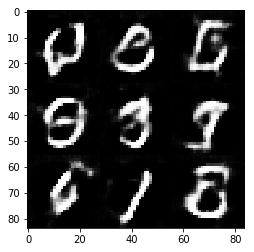

Step: 1210: Epoch 1/2... Discriminator Loss: 0.5844... Generator Loss: 2.2485
Step: 1220: Epoch 1/2... Discriminator Loss: 0.8824... Generator Loss: 1.1115
Step: 1230: Epoch 1/2... Discriminator Loss: 0.4468... Generator Loss: 3.2961
Step: 1240: Epoch 1/2... Discriminator Loss: 0.7036... Generator Loss: 1.7443
Step: 1250: Epoch 1/2... Discriminator Loss: 0.4645... Generator Loss: 2.4919
Step: 1260: Epoch 1/2... Discriminator Loss: 0.4212... Generator Loss: 2.9748
Step: 1270: Epoch 1/2... Discriminator Loss: 0.4885... Generator Loss: 2.7103
Step: 1280: Epoch 1/2... Discriminator Loss: 0.6661... Generator Loss: 1.8573
Step: 1290: Epoch 1/2... Discriminator Loss: 0.5172... Generator Loss: 2.1174
Step: 1300: Epoch 1/2... Discriminator Loss: 0.5037... Generator Loss: 2.0975


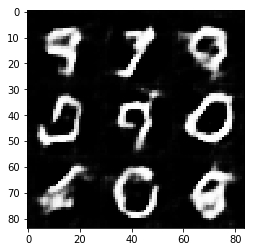

Step: 1310: Epoch 1/2... Discriminator Loss: 0.4545... Generator Loss: 2.9860
Step: 1320: Epoch 1/2... Discriminator Loss: 0.4192... Generator Loss: 3.3898
Step: 1330: Epoch 1/2... Discriminator Loss: 0.4158... Generator Loss: 2.3689
Step: 1340: Epoch 1/2... Discriminator Loss: 0.4715... Generator Loss: 3.0608
Step: 1350: Epoch 1/2... Discriminator Loss: 0.5008... Generator Loss: 2.5047
Step: 1360: Epoch 1/2... Discriminator Loss: 0.6418... Generator Loss: 4.3879
Step: 1370: Epoch 1/2... Discriminator Loss: 0.7288... Generator Loss: 1.7105
Step: 1380: Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 1.3024
Step: 1390: Epoch 1/2... Discriminator Loss: 0.4092... Generator Loss: 2.8352
Step: 1400: Epoch 1/2... Discriminator Loss: 0.4844... Generator Loss: 2.0572


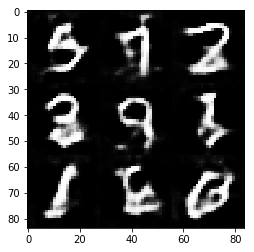

Step: 1410: Epoch 1/2... Discriminator Loss: 0.4659... Generator Loss: 2.7631
Step: 1420: Epoch 1/2... Discriminator Loss: 0.5137... Generator Loss: 2.1362
Step: 1430: Epoch 1/2... Discriminator Loss: 0.5144... Generator Loss: 2.4445
Step: 1440: Epoch 1/2... Discriminator Loss: 0.5691... Generator Loss: 3.7267
Step: 1450: Epoch 1/2... Discriminator Loss: 0.4862... Generator Loss: 2.9365
Step: 1460: Epoch 1/2... Discriminator Loss: 0.5507... Generator Loss: 2.8416
Step: 1470: Epoch 1/2... Discriminator Loss: 0.4845... Generator Loss: 2.9231
Step: 1480: Epoch 1/2... Discriminator Loss: 0.4804... Generator Loss: 2.4806
Step: 1490: Epoch 1/2... Discriminator Loss: 0.4411... Generator Loss: 3.4094
Step: 1500: Epoch 1/2... Discriminator Loss: 0.4537... Generator Loss: 2.4773


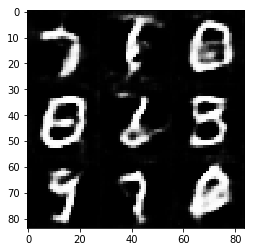

Step: 1510: Epoch 1/2... Discriminator Loss: 0.4813... Generator Loss: 3.5271
Step: 1520: Epoch 1/2... Discriminator Loss: 0.5463... Generator Loss: 2.0994
Step: 1530: Epoch 1/2... Discriminator Loss: 0.4674... Generator Loss: 3.0365
Step: 1540: Epoch 1/2... Discriminator Loss: 0.9077... Generator Loss: 1.3239
Step: 1550: Epoch 1/2... Discriminator Loss: 0.4188... Generator Loss: 2.7871
Step: 1560: Epoch 1/2... Discriminator Loss: 0.4625... Generator Loss: 2.7586
Step: 1570: Epoch 1/2... Discriminator Loss: 0.4150... Generator Loss: 2.3026
Step: 1580: Epoch 1/2... Discriminator Loss: 0.4344... Generator Loss: 3.1344
Step: 1590: Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.9761
Step: 1600: Epoch 1/2... Discriminator Loss: 0.5153... Generator Loss: 2.0612


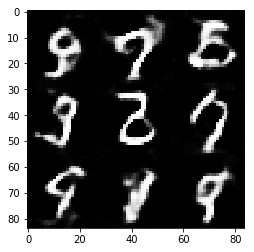

Step: 1610: Epoch 1/2... Discriminator Loss: 0.4472... Generator Loss: 3.0075
Step: 1620: Epoch 1/2... Discriminator Loss: 0.5366... Generator Loss: 3.4662
Step: 1630: Epoch 1/2... Discriminator Loss: 0.4417... Generator Loss: 2.6090
Step: 1640: Epoch 1/2... Discriminator Loss: 0.4477... Generator Loss: 2.8311
Step: 1650: Epoch 1/2... Discriminator Loss: 0.4088... Generator Loss: 3.0392
Step: 1660: Epoch 1/2... Discriminator Loss: 0.4923... Generator Loss: 2.6335
Step: 1670: Epoch 1/2... Discriminator Loss: 0.4162... Generator Loss: 2.5982
Step: 1680: Epoch 1/2... Discriminator Loss: 0.4037... Generator Loss: 2.8280
Step: 1690: Epoch 1/2... Discriminator Loss: 0.4660... Generator Loss: 2.4043
Step: 1700: Epoch 1/2... Discriminator Loss: 0.5720... Generator Loss: 2.3547


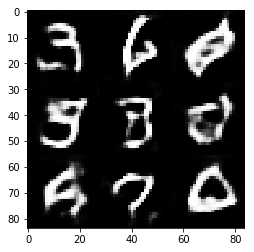

Step: 1710: Epoch 1/2... Discriminator Loss: 0.4909... Generator Loss: 3.0171
Step: 1720: Epoch 1/2... Discriminator Loss: 0.6307... Generator Loss: 1.8763
Step: 1730: Epoch 1/2... Discriminator Loss: 0.4240... Generator Loss: 2.5142
Step: 1740: Epoch 1/2... Discriminator Loss: 0.4184... Generator Loss: 2.8973
Step: 1750: Epoch 1/2... Discriminator Loss: 0.6546... Generator Loss: 2.1219
Step: 1760: Epoch 1/2... Discriminator Loss: 0.4570... Generator Loss: 2.5335
Step: 1770: Epoch 1/2... Discriminator Loss: 0.4994... Generator Loss: 2.1081
Step: 1780: Epoch 1/2... Discriminator Loss: 0.3924... Generator Loss: 3.2701
Step: 1790: Epoch 1/2... Discriminator Loss: 0.4233... Generator Loss: 2.9374
Step: 1800: Epoch 1/2... Discriminator Loss: 0.4670... Generator Loss: 3.0919


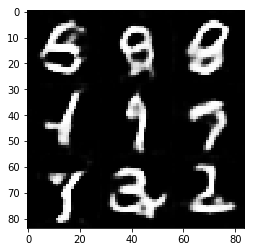

Step: 1810: Epoch 1/2... Discriminator Loss: 0.8445... Generator Loss: 1.7109
Step: 1820: Epoch 1/2... Discriminator Loss: 0.3953... Generator Loss: 3.8044
Step: 1830: Epoch 1/2... Discriminator Loss: 0.4886... Generator Loss: 3.6102
Step: 1840: Epoch 1/2... Discriminator Loss: 0.4867... Generator Loss: 1.9299
Step: 1850: Epoch 1/2... Discriminator Loss: 0.4387... Generator Loss: 3.4186
Step: 1860: Epoch 1/2... Discriminator Loss: 0.4053... Generator Loss: 3.7386
Step: 1870: Epoch 1/2... Discriminator Loss: 0.4505... Generator Loss: 2.8086
Step: 1880: Epoch 2/2... Discriminator Loss: 0.7380... Generator Loss: 1.4988
Step: 1890: Epoch 2/2... Discriminator Loss: 0.3830... Generator Loss: 2.6141
Step: 1900: Epoch 2/2... Discriminator Loss: 0.3871... Generator Loss: 3.0444


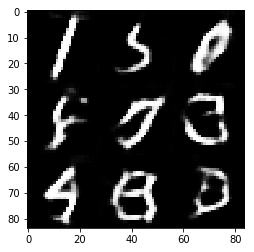

Step: 1910: Epoch 2/2... Discriminator Loss: 0.4381... Generator Loss: 3.1786
Step: 1920: Epoch 2/2... Discriminator Loss: 0.4056... Generator Loss: 3.2534
Step: 1930: Epoch 2/2... Discriminator Loss: 0.3973... Generator Loss: 4.0677
Step: 1940: Epoch 2/2... Discriminator Loss: 0.4109... Generator Loss: 3.0995
Step: 1950: Epoch 2/2... Discriminator Loss: 1.2126... Generator Loss: 1.0647
Step: 1960: Epoch 2/2... Discriminator Loss: 0.4626... Generator Loss: 3.1082
Step: 1970: Epoch 2/2... Discriminator Loss: 0.4147... Generator Loss: 2.8255
Step: 1980: Epoch 2/2... Discriminator Loss: 0.4155... Generator Loss: 2.8868
Step: 1990: Epoch 2/2... Discriminator Loss: 0.5181... Generator Loss: 3.4918
Step: 2000: Epoch 2/2... Discriminator Loss: 2.0605... Generator Loss: 0.6616


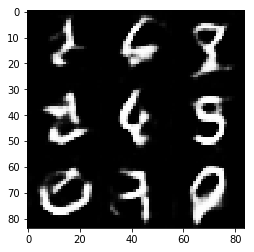

Step: 2010: Epoch 2/2... Discriminator Loss: 0.6658... Generator Loss: 1.6527
Step: 2020: Epoch 2/2... Discriminator Loss: 0.4699... Generator Loss: 2.9228
Step: 2030: Epoch 2/2... Discriminator Loss: 0.4163... Generator Loss: 2.7290
Step: 2040: Epoch 2/2... Discriminator Loss: 0.4421... Generator Loss: 2.6459
Step: 2050: Epoch 2/2... Discriminator Loss: 0.4213... Generator Loss: 3.0745
Step: 2060: Epoch 2/2... Discriminator Loss: 0.4838... Generator Loss: 2.3571
Step: 2070: Epoch 2/2... Discriminator Loss: 0.4139... Generator Loss: 2.7605
Step: 2080: Epoch 2/2... Discriminator Loss: 0.3888... Generator Loss: 3.0920
Step: 2090: Epoch 2/2... Discriminator Loss: 0.4731... Generator Loss: 3.5250
Step: 2100: Epoch 2/2... Discriminator Loss: 0.6620... Generator Loss: 1.9493


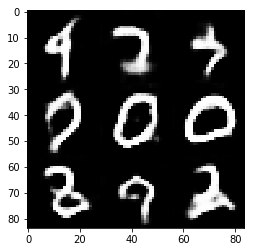

Step: 2110: Epoch 2/2... Discriminator Loss: 0.5380... Generator Loss: 1.9621
Step: 2120: Epoch 2/2... Discriminator Loss: 0.6532... Generator Loss: 4.1544
Step: 2130: Epoch 2/2... Discriminator Loss: 0.5401... Generator Loss: 2.0491
Step: 2140: Epoch 2/2... Discriminator Loss: 0.3840... Generator Loss: 3.5023
Step: 2150: Epoch 2/2... Discriminator Loss: 0.9403... Generator Loss: 1.4124
Step: 2160: Epoch 2/2... Discriminator Loss: 0.4170... Generator Loss: 2.7570
Step: 2170: Epoch 2/2... Discriminator Loss: 0.5658... Generator Loss: 1.7446
Step: 2180: Epoch 2/2... Discriminator Loss: 0.4376... Generator Loss: 3.1244
Step: 2190: Epoch 2/2... Discriminator Loss: 0.4177... Generator Loss: 2.8413
Step: 2200: Epoch 2/2... Discriminator Loss: 0.4432... Generator Loss: 3.9042


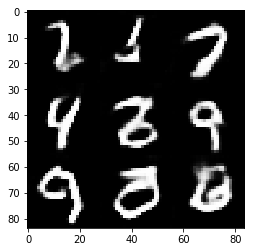

Step: 2210: Epoch 2/2... Discriminator Loss: 0.4072... Generator Loss: 2.6314
Step: 2220: Epoch 2/2... Discriminator Loss: 0.5114... Generator Loss: 2.6191
Step: 2230: Epoch 2/2... Discriminator Loss: 0.3887... Generator Loss: 3.5949
Step: 2240: Epoch 2/2... Discriminator Loss: 0.3925... Generator Loss: 3.8522
Step: 2250: Epoch 2/2... Discriminator Loss: 3.0634... Generator Loss: 0.2383
Step: 2260: Epoch 2/2... Discriminator Loss: 0.6150... Generator Loss: 1.4626
Step: 2270: Epoch 2/2... Discriminator Loss: 0.4093... Generator Loss: 2.7801
Step: 2280: Epoch 2/2... Discriminator Loss: 0.4517... Generator Loss: 2.5601
Step: 2290: Epoch 2/2... Discriminator Loss: 0.7752... Generator Loss: 1.6760
Step: 2300: Epoch 2/2... Discriminator Loss: 0.4683... Generator Loss: 2.5874


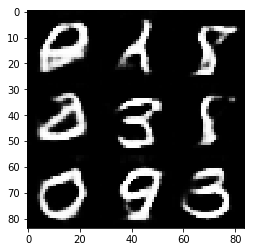

Step: 2310: Epoch 2/2... Discriminator Loss: 0.4977... Generator Loss: 2.2601
Step: 2320: Epoch 2/2... Discriminator Loss: 0.4630... Generator Loss: 2.7771
Step: 2330: Epoch 2/2... Discriminator Loss: 0.4062... Generator Loss: 3.1959
Step: 2340: Epoch 2/2... Discriminator Loss: 0.4286... Generator Loss: 3.8039
Step: 2350: Epoch 2/2... Discriminator Loss: 0.5567... Generator Loss: 1.8766
Step: 2360: Epoch 2/2... Discriminator Loss: 0.4417... Generator Loss: 2.6580
Step: 2370: Epoch 2/2... Discriminator Loss: 0.5038... Generator Loss: 2.2591
Step: 2380: Epoch 2/2... Discriminator Loss: 0.3639... Generator Loss: 3.5041
Step: 2390: Epoch 2/2... Discriminator Loss: 0.3802... Generator Loss: 3.4256
Step: 2400: Epoch 2/2... Discriminator Loss: 0.4045... Generator Loss: 3.1072


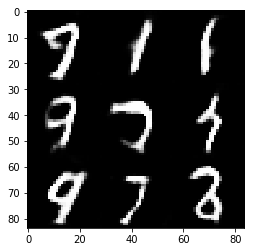

Step: 2410: Epoch 2/2... Discriminator Loss: 0.4686... Generator Loss: 2.6389
Step: 2420: Epoch 2/2... Discriminator Loss: 0.6505... Generator Loss: 4.1907
Step: 2430: Epoch 2/2... Discriminator Loss: 0.3942... Generator Loss: 4.0643
Step: 2440: Epoch 2/2... Discriminator Loss: 0.4002... Generator Loss: 3.1162
Step: 2450: Epoch 2/2... Discriminator Loss: 0.4087... Generator Loss: 4.2887
Step: 2460: Epoch 2/2... Discriminator Loss: 0.4055... Generator Loss: 4.5897
Step: 2470: Epoch 2/2... Discriminator Loss: 0.4249... Generator Loss: 2.9590
Step: 2480: Epoch 2/2... Discriminator Loss: 0.3909... Generator Loss: 3.3630
Step: 2490: Epoch 2/2... Discriminator Loss: 0.3707... Generator Loss: 4.0762
Step: 2500: Epoch 2/2... Discriminator Loss: 0.3594... Generator Loss: 3.7685


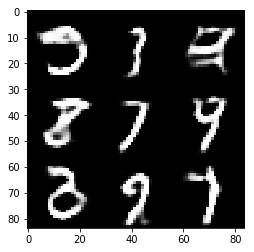

Step: 2510: Epoch 2/2... Discriminator Loss: 0.3737... Generator Loss: 3.9058
Step: 2520: Epoch 2/2... Discriminator Loss: 0.4061... Generator Loss: 4.2729
Step: 2530: Epoch 2/2... Discriminator Loss: 0.8263... Generator Loss: 1.2599
Step: 2540: Epoch 2/2... Discriminator Loss: 0.3663... Generator Loss: 3.6704
Step: 2550: Epoch 2/2... Discriminator Loss: 0.4239... Generator Loss: 2.8539
Step: 2560: Epoch 2/2... Discriminator Loss: 0.3727... Generator Loss: 3.6025
Step: 2570: Epoch 2/2... Discriminator Loss: 0.3761... Generator Loss: 4.0166
Step: 2580: Epoch 2/2... Discriminator Loss: 0.3558... Generator Loss: 4.0627
Step: 2590: Epoch 2/2... Discriminator Loss: 0.3773... Generator Loss: 3.9542
Step: 2600: Epoch 2/2... Discriminator Loss: 2.3958... Generator Loss: 7.9648


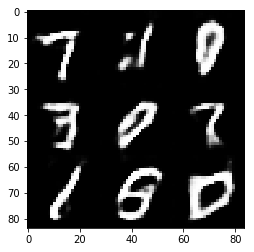

Step: 2610: Epoch 2/2... Discriminator Loss: 0.4726... Generator Loss: 2.1283
Step: 2620: Epoch 2/2... Discriminator Loss: 0.4181... Generator Loss: 3.8308
Step: 2630: Epoch 2/2... Discriminator Loss: 0.3999... Generator Loss: 3.2416
Step: 2640: Epoch 2/2... Discriminator Loss: 0.4801... Generator Loss: 2.3776
Step: 2650: Epoch 2/2... Discriminator Loss: 0.3557... Generator Loss: 3.8270
Step: 2660: Epoch 2/2... Discriminator Loss: 0.3775... Generator Loss: 3.7578
Step: 2670: Epoch 2/2... Discriminator Loss: 0.3696... Generator Loss: 3.9941
Step: 2680: Epoch 2/2... Discriminator Loss: 0.4199... Generator Loss: 3.1737
Step: 2690: Epoch 2/2... Discriminator Loss: 0.3720... Generator Loss: 3.8287
Step: 2700: Epoch 2/2... Discriminator Loss: 0.3696... Generator Loss: 3.5977


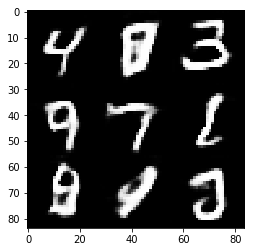

Step: 2710: Epoch 2/2... Discriminator Loss: 0.3709... Generator Loss: 4.0702
Step: 2720: Epoch 2/2... Discriminator Loss: 0.3499... Generator Loss: 3.9323
Step: 2730: Epoch 2/2... Discriminator Loss: 0.3715... Generator Loss: 3.6481
Step: 2740: Epoch 2/2... Discriminator Loss: 0.3836... Generator Loss: 3.5552
Step: 2750: Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 1.7126
Step: 2760: Epoch 2/2... Discriminator Loss: 0.3583... Generator Loss: 3.5705
Step: 2770: Epoch 2/2... Discriminator Loss: 3.3048... Generator Loss: 7.6996
Step: 2780: Epoch 2/2... Discriminator Loss: 0.5078... Generator Loss: 2.5965
Step: 2790: Epoch 2/2... Discriminator Loss: 1.4130... Generator Loss: 0.7013
Step: 2800: Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 1.5709


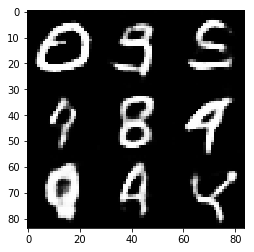

Step: 2810: Epoch 2/2... Discriminator Loss: 0.4583... Generator Loss: 2.7290
Step: 2820: Epoch 2/2... Discriminator Loss: 0.3789... Generator Loss: 3.6401
Step: 2830: Epoch 2/2... Discriminator Loss: 0.3910... Generator Loss: 3.8322
Step: 2840: Epoch 2/2... Discriminator Loss: 0.4392... Generator Loss: 2.5288
Step: 2850: Epoch 2/2... Discriminator Loss: 0.3832... Generator Loss: 3.7813
Step: 2860: Epoch 2/2... Discriminator Loss: 0.3669... Generator Loss: 4.3350
Step: 2870: Epoch 2/2... Discriminator Loss: 0.3799... Generator Loss: 3.8031
Step: 2880: Epoch 2/2... Discriminator Loss: 0.3569... Generator Loss: 3.8326
Step: 2890: Epoch 2/2... Discriminator Loss: 0.3487... Generator Loss: 4.1781
Step: 2900: Epoch 2/2... Discriminator Loss: 0.3837... Generator Loss: 3.2556


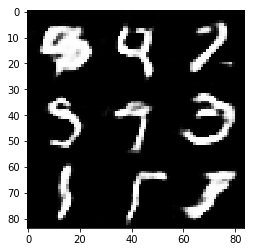

Step: 2910: Epoch 2/2... Discriminator Loss: 0.3554... Generator Loss: 4.4804
Step: 2920: Epoch 2/2... Discriminator Loss: 0.3637... Generator Loss: 4.1179
Step: 2930: Epoch 2/2... Discriminator Loss: 0.3885... Generator Loss: 4.1989
Step: 2940: Epoch 2/2... Discriminator Loss: 0.3732... Generator Loss: 3.9696
Step: 2950: Epoch 2/2... Discriminator Loss: 0.3588... Generator Loss: 3.5189
Step: 2960: Epoch 2/2... Discriminator Loss: 0.3619... Generator Loss: 3.3190
Step: 2970: Epoch 2/2... Discriminator Loss: 0.3550... Generator Loss: 3.4546
Step: 2980: Epoch 2/2... Discriminator Loss: 0.3939... Generator Loss: 3.7925
Step: 2990: Epoch 2/2... Discriminator Loss: 0.3524... Generator Loss: 3.7200
Step: 3000: Epoch 2/2... Discriminator Loss: 0.3542... Generator Loss: 3.9897


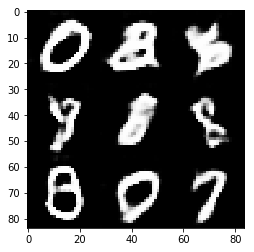

Step: 3010: Epoch 2/2... Discriminator Loss: 0.3496... Generator Loss: 4.0476
Step: 3020: Epoch 2/2... Discriminator Loss: 0.4183... Generator Loss: 2.7991
Step: 3030: Epoch 2/2... Discriminator Loss: 3.2629... Generator Loss: 0.1280
Step: 3040: Epoch 2/2... Discriminator Loss: 0.4019... Generator Loss: 3.1056
Step: 3050: Epoch 2/2... Discriminator Loss: 0.4064... Generator Loss: 3.1929
Step: 3060: Epoch 2/2... Discriminator Loss: 0.4210... Generator Loss: 3.8853
Step: 3070: Epoch 2/2... Discriminator Loss: 0.3607... Generator Loss: 4.5312
Step: 3080: Epoch 2/2... Discriminator Loss: 0.3561... Generator Loss: 3.7858
Step: 3090: Epoch 2/2... Discriminator Loss: 0.3488... Generator Loss: 4.7297
Step: 3100: Epoch 2/2... Discriminator Loss: 0.3487... Generator Loss: 4.9142


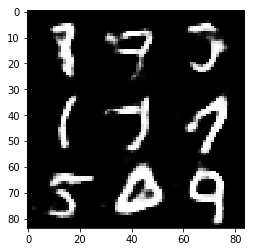

Step: 3110: Epoch 2/2... Discriminator Loss: 0.5545... Generator Loss: 2.5756
Step: 3120: Epoch 2/2... Discriminator Loss: 0.3502... Generator Loss: 4.3079
Step: 3130: Epoch 2/2... Discriminator Loss: 0.4059... Generator Loss: 3.5218
Step: 3140: Epoch 2/2... Discriminator Loss: 0.4341... Generator Loss: 2.7701
Step: 3150: Epoch 2/2... Discriminator Loss: 0.3646... Generator Loss: 4.1756
Step: 3160: Epoch 2/2... Discriminator Loss: 0.3523... Generator Loss: 5.0840
Step: 3170: Epoch 2/2... Discriminator Loss: 0.4007... Generator Loss: 3.1012
Step: 3180: Epoch 2/2... Discriminator Loss: 0.3672... Generator Loss: 3.9692
Step: 3190: Epoch 2/2... Discriminator Loss: 0.3757... Generator Loss: 3.2884
Step: 3200: Epoch 2/2... Discriminator Loss: 0.3731... Generator Loss: 3.9302


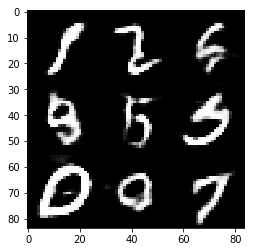

Step: 3210: Epoch 2/2... Discriminator Loss: 0.3573... Generator Loss: 3.5918
Step: 3220: Epoch 2/2... Discriminator Loss: 0.3587... Generator Loss: 4.1111
Step: 3230: Epoch 2/2... Discriminator Loss: 0.4038... Generator Loss: 3.6504
Step: 3240: Epoch 2/2... Discriminator Loss: 0.3487... Generator Loss: 4.1949
Step: 3250: Epoch 2/2... Discriminator Loss: 0.3550... Generator Loss: 3.6649
Step: 3260: Epoch 2/2... Discriminator Loss: 0.3757... Generator Loss: 3.6847
Step: 3270: Epoch 2/2... Discriminator Loss: 0.3439... Generator Loss: 4.0816
Step: 3280: Epoch 2/2... Discriminator Loss: 0.3414... Generator Loss: 5.1907
Step: 3290: Epoch 2/2... Discriminator Loss: 0.3430... Generator Loss: 5.1413
Step: 3300: Epoch 2/2... Discriminator Loss: 3.5333... Generator Loss: 8.8432


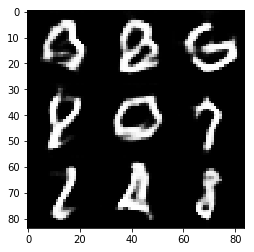

Step: 3310: Epoch 2/2... Discriminator Loss: 0.4241... Generator Loss: 3.3433
Step: 3320: Epoch 2/2... Discriminator Loss: 0.3587... Generator Loss: 3.9397
Step: 3330: Epoch 2/2... Discriminator Loss: 0.3708... Generator Loss: 3.4566
Step: 3340: Epoch 2/2... Discriminator Loss: 0.4044... Generator Loss: 3.3719
Step: 3350: Epoch 2/2... Discriminator Loss: 0.4207... Generator Loss: 3.1766
Step: 3360: Epoch 2/2... Discriminator Loss: 0.3750... Generator Loss: 3.6744
Step: 3370: Epoch 2/2... Discriminator Loss: 0.3645... Generator Loss: 4.0414
Step: 3380: Epoch 2/2... Discriminator Loss: 0.3587... Generator Loss: 4.2906
Step: 3390: Epoch 2/2... Discriminator Loss: 0.3633... Generator Loss: 3.9032
Step: 3400: Epoch 2/2... Discriminator Loss: 0.3487... Generator Loss: 3.9344


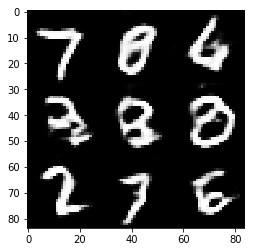

Step: 3410: Epoch 2/2... Discriminator Loss: 0.5074... Generator Loss: 2.2286
Step: 3420: Epoch 2/2... Discriminator Loss: 0.4293... Generator Loss: 2.8845
Step: 3430: Epoch 2/2... Discriminator Loss: 0.4213... Generator Loss: 3.3354
Step: 3440: Epoch 2/2... Discriminator Loss: 0.4285... Generator Loss: 3.0956
Step: 3450: Epoch 2/2... Discriminator Loss: 0.4042... Generator Loss: 3.6941
Step: 3460: Epoch 2/2... Discriminator Loss: 0.3590... Generator Loss: 3.7473
Step: 3470: Epoch 2/2... Discriminator Loss: 0.3496... Generator Loss: 4.3562
Step: 3480: Epoch 2/2... Discriminator Loss: 0.3651... Generator Loss: 3.5017
Step: 3490: Epoch 2/2... Discriminator Loss: 0.4030... Generator Loss: 2.7839
Step: 3500: Epoch 2/2... Discriminator Loss: 0.3625... Generator Loss: 4.0993


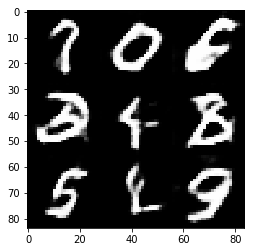

Step: 3510: Epoch 2/2... Discriminator Loss: 0.3553... Generator Loss: 3.6291
Step: 3520: Epoch 2/2... Discriminator Loss: 0.3748... Generator Loss: 4.5150
Step: 3530: Epoch 2/2... Discriminator Loss: 0.3503... Generator Loss: 4.2763
Step: 3540: Epoch 2/2... Discriminator Loss: 0.3521... Generator Loss: 4.2746
Step: 3550: Epoch 2/2... Discriminator Loss: 0.3823... Generator Loss: 3.9806
Step: 3560: Epoch 2/2... Discriminator Loss: 0.3679... Generator Loss: 3.5059
Step: 3570: Epoch 2/2... Discriminator Loss: 0.3541... Generator Loss: 3.8773
Step: 3580: Epoch 2/2... Discriminator Loss: 0.3825... Generator Loss: 3.3738
Step: 3590: Epoch 2/2... Discriminator Loss: 0.3884... Generator Loss: 4.1538
Step: 3600: Epoch 2/2... Discriminator Loss: 0.3838... Generator Loss: 3.4094


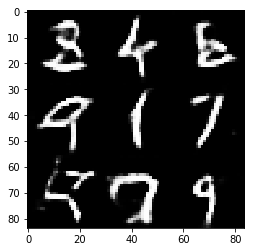

Step: 3610: Epoch 2/2... Discriminator Loss: 0.3441... Generator Loss: 4.0296
Step: 3620: Epoch 2/2... Discriminator Loss: 0.4559... Generator Loss: 3.0690
Step: 3630: Epoch 2/2... Discriminator Loss: 0.3919... Generator Loss: 4.3185
Step: 3640: Epoch 2/2... Discriminator Loss: 0.3431... Generator Loss: 5.1694
Step: 3650: Epoch 2/2... Discriminator Loss: 0.5842... Generator Loss: 2.2608
Step: 3660: Epoch 2/2... Discriminator Loss: 0.4758... Generator Loss: 2.3628
Step: 3670: Epoch 2/2... Discriminator Loss: 0.3836... Generator Loss: 3.4197
Step: 3680: Epoch 2/2... Discriminator Loss: 0.3486... Generator Loss: 3.7736
Step: 3690: Epoch 2/2... Discriminator Loss: 0.3605... Generator Loss: 4.2863
Step: 3700: Epoch 2/2... Discriminator Loss: 0.3464... Generator Loss: 4.7179


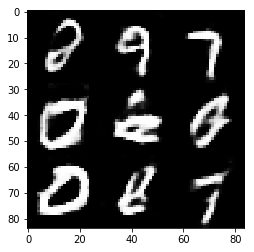

Step: 3710: Epoch 2/2... Discriminator Loss: 0.4288... Generator Loss: 3.5082
Step: 3720: Epoch 2/2... Discriminator Loss: 1.1325... Generator Loss: 4.8251
Step: 3730: Epoch 2/2... Discriminator Loss: 0.3900... Generator Loss: 2.7900
Step: 3740: Epoch 2/2... Discriminator Loss: 0.3827... Generator Loss: 3.2182
Step: 3750: Epoch 2/2... Discriminator Loss: 0.4062... Generator Loss: 3.0669
Training done!


In [32]:
batch_size = 32
z_dim = 128
learning_rate = 0.00015
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Trainning start ...
Step: 10: Epoch 1/1... Discriminator Loss: 0.4652... Generator Loss: 2.9185
Step: 20: Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 3.4244
Step: 30: Epoch 1/1... Discriminator Loss: 0.4355... Generator Loss: 5.2977
Step: 40: Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 4.2663
Step: 50: Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 5.1247
Step: 60: Epoch 1/1... Discriminator Loss: 0.4091... Generator Loss: 3.6291
Step: 70: Epoch 1/1... Discriminator Loss: 0.4883... Generator Loss: 9.3681
Step: 80: Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 2.4960
Step: 90: Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 2.3229
Step: 100: Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 3.8209


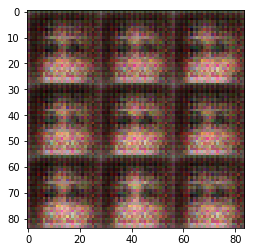

Step: 110: Epoch 1/1... Discriminator Loss: 0.3578... Generator Loss: 4.5126
Step: 120: Epoch 1/1... Discriminator Loss: 0.3824... Generator Loss: 3.7834
Step: 130: Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 3.8943
Step: 140: Epoch 1/1... Discriminator Loss: 0.5731... Generator Loss: 2.1773
Step: 150: Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 4.9397
Step: 160: Epoch 1/1... Discriminator Loss: 0.4007... Generator Loss: 5.7991
Step: 170: Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 5.0350
Step: 180: Epoch 1/1... Discriminator Loss: 3.4310... Generator Loss: 0.3543
Step: 190: Epoch 1/1... Discriminator Loss: 0.4478... Generator Loss: 2.7485
Step: 200: Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 2.4518


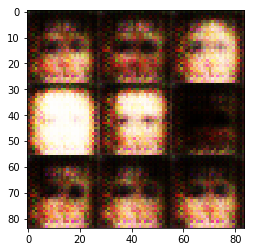

Step: 210: Epoch 1/1... Discriminator Loss: 0.4719... Generator Loss: 3.6068
Step: 220: Epoch 1/1... Discriminator Loss: 0.4208... Generator Loss: 3.2528
Step: 230: Epoch 1/1... Discriminator Loss: 0.3728... Generator Loss: 4.0985
Step: 240: Epoch 1/1... Discriminator Loss: 0.4168... Generator Loss: 3.0115
Step: 250: Epoch 1/1... Discriminator Loss: 0.3763... Generator Loss: 3.3097
Step: 260: Epoch 1/1... Discriminator Loss: 0.3715... Generator Loss: 4.6099
Step: 270: Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 2.1318
Step: 280: Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 3.5307
Step: 290: Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 4.1401
Step: 300: Epoch 1/1... Discriminator Loss: 0.3569... Generator Loss: 4.9503


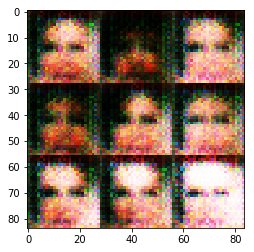

Step: 310: Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 3.5589
Step: 320: Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 4.2897
Step: 330: Epoch 1/1... Discriminator Loss: 0.3572... Generator Loss: 3.9077
Step: 340: Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 4.0621
Step: 350: Epoch 1/1... Discriminator Loss: 0.4199... Generator Loss: 3.1465
Step: 360: Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 4.0948
Step: 370: Epoch 1/1... Discriminator Loss: 0.3426... Generator Loss: 5.5582
Step: 380: Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 4.8465
Step: 390: Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 4.7492
Step: 400: Epoch 1/1... Discriminator Loss: 0.4259... Generator Loss: 3.0311


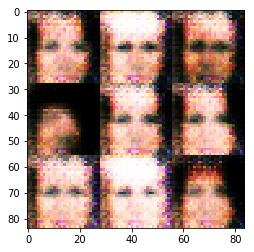

Step: 410: Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 7.2207
Step: 420: Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 2.8992
Step: 430: Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 3.9366
Step: 440: Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 4.8738
Step: 450: Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 4.8208
Step: 460: Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 3.7936
Step: 470: Epoch 1/1... Discriminator Loss: 0.3597... Generator Loss: 3.8248
Step: 480: Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 5.4616
Step: 490: Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 3.6693
Step: 500: Epoch 1/1... Discriminator Loss: 0.3552... Generator Loss: 4.2179


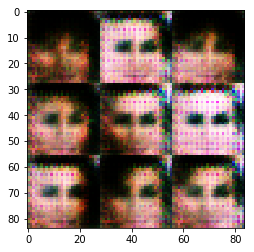

Step: 510: Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 4.0298
Step: 520: Epoch 1/1... Discriminator Loss: 0.3706... Generator Loss: 3.8571
Step: 530: Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 3.4821
Step: 540: Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 2.8865
Step: 550: Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 3.0918
Step: 560: Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 4.0585
Step: 570: Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 2.1845
Step: 580: Epoch 1/1... Discriminator Loss: 0.3956... Generator Loss: 3.7089
Step: 590: Epoch 1/1... Discriminator Loss: 0.4405... Generator Loss: 2.7993
Step: 600: Epoch 1/1... Discriminator Loss: 0.4110... Generator Loss: 3.4517


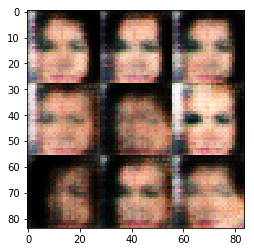

Step: 610: Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 4.3543
Step: 620: Epoch 1/1... Discriminator Loss: 0.3749... Generator Loss: 3.5323
Step: 630: Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 4.0338
Step: 640: Epoch 1/1... Discriminator Loss: 0.4434... Generator Loss: 3.3383
Step: 650: Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 2.4993
Step: 660: Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 2.7814
Step: 670: Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.4541
Step: 680: Epoch 1/1... Discriminator Loss: 0.4007... Generator Loss: 3.0484
Step: 690: Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.6997
Step: 700: Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 1.8186


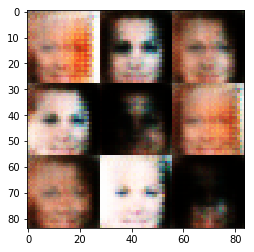

Step: 710: Epoch 1/1... Discriminator Loss: 0.4264... Generator Loss: 2.9551
Step: 720: Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 4.1807
Step: 730: Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.1415
Step: 740: Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 3.2615
Step: 750: Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 2.6380
Step: 760: Epoch 1/1... Discriminator Loss: 0.4342... Generator Loss: 3.6744
Step: 770: Epoch 1/1... Discriminator Loss: 0.5555... Generator Loss: 4.2520
Step: 780: Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 1.0274
Step: 790: Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 3.6922
Step: 800: Epoch 1/1... Discriminator Loss: 0.5329... Generator Loss: 2.1956


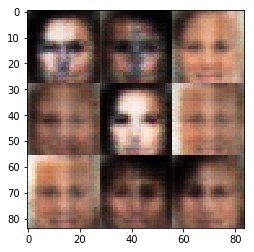

Step: 810: Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 3.2997
Step: 820: Epoch 1/1... Discriminator Loss: 0.4669... Generator Loss: 2.6542
Step: 830: Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 2.2652
Step: 840: Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 1.7198
Step: 850: Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 1.4056
Step: 860: Epoch 1/1... Discriminator Loss: 0.6709... Generator Loss: 7.0494
Step: 870: Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 2.6122
Step: 880: Epoch 1/1... Discriminator Loss: 0.4164... Generator Loss: 3.2133
Step: 890: Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 3.3824
Step: 900: Epoch 1/1... Discriminator Loss: 2.4928... Generator Loss: 8.0152


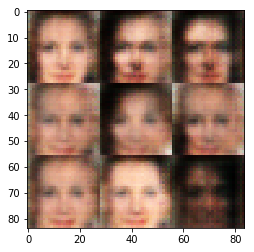

Step: 910: Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 2.2496
Step: 920: Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 3.4652
Step: 930: Epoch 1/1... Discriminator Loss: 0.4328... Generator Loss: 3.5584
Step: 940: Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 3.1479
Step: 950: Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 2.9879
Step: 960: Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 3.5847
Step: 970: Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 4.0675
Step: 980: Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 5.0232
Step: 990: Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 5.1486
Step: 1000: Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 3.3874


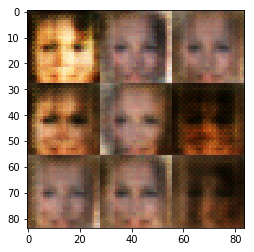

Step: 1010: Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 3.9745
Step: 1020: Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 3.0418
Step: 1030: Epoch 1/1... Discriminator Loss: 0.4932... Generator Loss: 2.3493
Step: 1040: Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 3.6539
Step: 1050: Epoch 1/1... Discriminator Loss: 0.4088... Generator Loss: 3.9494
Step: 1060: Epoch 1/1... Discriminator Loss: 0.4779... Generator Loss: 3.0835
Step: 1070: Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 2.5244
Step: 1080: Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 3.5743
Step: 1090: Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 2.8028
Step: 1100: Epoch 1/1... Discriminator Loss: 0.4346... Generator Loss: 3.1655


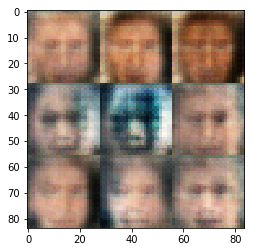

Step: 1110: Epoch 1/1... Discriminator Loss: 0.4925... Generator Loss: 2.8720
Step: 1120: Epoch 1/1... Discriminator Loss: 0.4355... Generator Loss: 3.7777
Step: 1130: Epoch 1/1... Discriminator Loss: 0.4845... Generator Loss: 4.6311
Step: 1140: Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 2.9958
Step: 1150: Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 7.3436
Step: 1160: Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 2.8829
Step: 1170: Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 2.6471
Step: 1180: Epoch 1/1... Discriminator Loss: 0.4584... Generator Loss: 2.6838
Step: 1190: Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 4.3817
Step: 1200: Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 3.4380


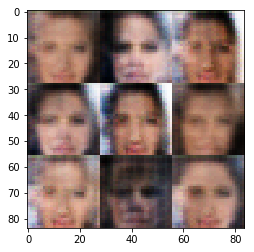

Step: 1210: Epoch 1/1... Discriminator Loss: 0.4290... Generator Loss: 3.4442
Step: 1220: Epoch 1/1... Discriminator Loss: 0.6724... Generator Loss: 1.9168
Step: 1230: Epoch 1/1... Discriminator Loss: 0.5117... Generator Loss: 3.8326
Step: 1240: Epoch 1/1... Discriminator Loss: 0.4553... Generator Loss: 3.2884
Step: 1250: Epoch 1/1... Discriminator Loss: 0.5642... Generator Loss: 2.3062
Step: 1260: Epoch 1/1... Discriminator Loss: 0.5362... Generator Loss: 5.3280
Step: 1270: Epoch 1/1... Discriminator Loss: 0.4433... Generator Loss: 3.2960
Step: 1280: Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 2.4588
Step: 1290: Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 2.7368
Step: 1300: Epoch 1/1... Discriminator Loss: 0.4953... Generator Loss: 3.6971


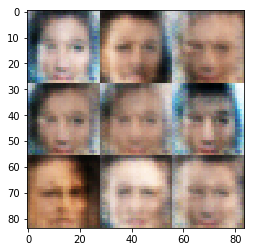

Step: 1310: Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 3.0566
Step: 1320: Epoch 1/1... Discriminator Loss: 2.0128... Generator Loss: 7.5787
Step: 1330: Epoch 1/1... Discriminator Loss: 0.5737... Generator Loss: 4.2018
Step: 1340: Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 4.1236
Step: 1350: Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 2.7410
Step: 1360: Epoch 1/1... Discriminator Loss: 0.4746... Generator Loss: 2.7970
Step: 1370: Epoch 1/1... Discriminator Loss: 0.4372... Generator Loss: 2.9437
Step: 1380: Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 3.0785
Step: 1390: Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 3.6768
Step: 1400: Epoch 1/1... Discriminator Loss: 0.4597... Generator Loss: 3.1285


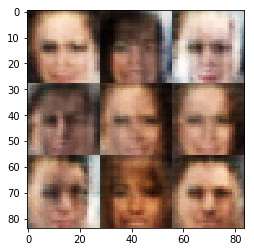

Step: 1410: Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 2.5966
Step: 1420: Epoch 1/1... Discriminator Loss: 0.4627... Generator Loss: 4.5847
Step: 1430: Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 2.4041
Step: 1440: Epoch 1/1... Discriminator Loss: 0.4127... Generator Loss: 3.2897
Step: 1450: Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 3.5949
Step: 1460: Epoch 1/1... Discriminator Loss: 0.4254... Generator Loss: 3.8628
Step: 1470: Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 4.9727
Step: 1480: Epoch 1/1... Discriminator Loss: 0.4308... Generator Loss: 3.0357
Step: 1490: Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 4.2266
Step: 1500: Epoch 1/1... Discriminator Loss: 0.4633... Generator Loss: 3.6284


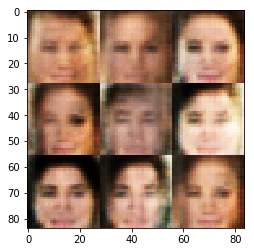

Step: 1510: Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 2.5203
Step: 1520: Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 2.4110
Step: 1530: Epoch 1/1... Discriminator Loss: 0.5687... Generator Loss: 2.3588
Step: 1540: Epoch 1/1... Discriminator Loss: 0.6618... Generator Loss: 1.7558
Step: 1550: Epoch 1/1... Discriminator Loss: 0.6312... Generator Loss: 4.6082
Step: 1560: Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 3.2041
Step: 1570: Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 2.2692
Step: 1580: Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 3.9281
Step: 1590: Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 2.5474
Step: 1600: Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 2.8902


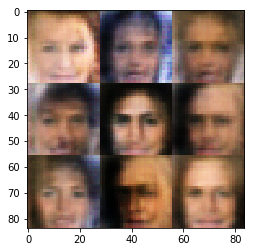

Step: 1610: Epoch 1/1... Discriminator Loss: 0.4462... Generator Loss: 2.9909
Step: 1620: Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 2.8331
Step: 1630: Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 3.6558
Step: 1640: Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 2.4601
Step: 1650: Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 2.7998
Step: 1660: Epoch 1/1... Discriminator Loss: 0.4137... Generator Loss: 3.4811
Step: 1670: Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 2.4601
Step: 1680: Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 4.2752
Step: 1690: Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 4.2445
Step: 1700: Epoch 1/1... Discriminator Loss: 0.4258... Generator Loss: 2.8393


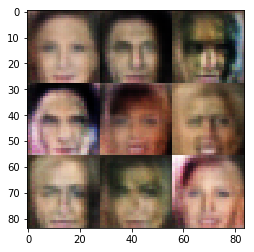

Step: 1710: Epoch 1/1... Discriminator Loss: 0.5771... Generator Loss: 4.6580
Step: 1720: Epoch 1/1... Discriminator Loss: 0.4567... Generator Loss: 2.7247
Step: 1730: Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 4.1274
Step: 1740: Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 1.8074
Step: 1750: Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 2.0315
Step: 1760: Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 4.8726
Step: 1770: Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 3.2837
Step: 1780: Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 2.7162
Step: 1790: Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 2.3867
Step: 1800: Epoch 1/1... Discriminator Loss: 0.4147... Generator Loss: 3.0750


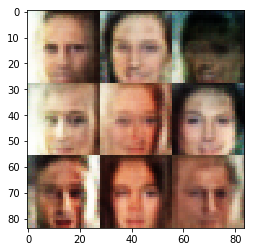

Step: 1810: Epoch 1/1... Discriminator Loss: 0.4507... Generator Loss: 2.8122
Step: 1820: Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 2.8128
Step: 1830: Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 4.4468
Step: 1840: Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 3.4860
Step: 1850: Epoch 1/1... Discriminator Loss: 0.4603... Generator Loss: 2.5218
Step: 1860: Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 3.2655
Step: 1870: Epoch 1/1... Discriminator Loss: 0.4506... Generator Loss: 2.8498
Step: 1880: Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 2.8791
Step: 1890: Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 2.2594
Step: 1900: Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 2.2794


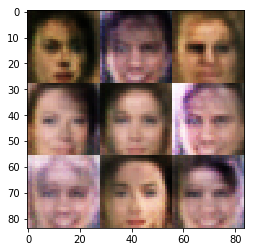

Step: 1910: Epoch 1/1... Discriminator Loss: 0.4814... Generator Loss: 2.6626
Step: 1920: Epoch 1/1... Discriminator Loss: 0.5435... Generator Loss: 1.9160
Step: 1930: Epoch 1/1... Discriminator Loss: 0.4231... Generator Loss: 2.7345
Step: 1940: Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 2.7453
Step: 1950: Epoch 1/1... Discriminator Loss: 0.5417... Generator Loss: 2.2336
Step: 1960: Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 5.0796
Step: 1970: Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 3.5797
Step: 1980: Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 2.3053
Step: 1990: Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 2.9864
Step: 2000: Epoch 1/1... Discriminator Loss: 0.4260... Generator Loss: 3.2622


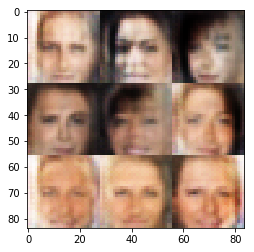

Step: 2010: Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 2.9684
Step: 2020: Epoch 1/1... Discriminator Loss: 0.5189... Generator Loss: 3.3888
Step: 2030: Epoch 1/1... Discriminator Loss: 0.6787... Generator Loss: 1.6288
Step: 2040: Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 3.7172
Step: 2050: Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 3.2394
Step: 2060: Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 2.2697
Step: 2070: Epoch 1/1... Discriminator Loss: 0.5272... Generator Loss: 2.3885
Step: 2080: Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 4.5982
Step: 2090: Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 1.8138
Step: 2100: Epoch 1/1... Discriminator Loss: 0.4910... Generator Loss: 3.0286


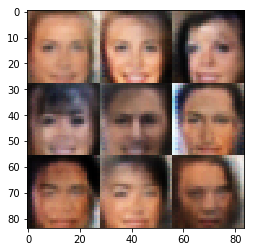

Step: 2110: Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 2.5301
Step: 2120: Epoch 1/1... Discriminator Loss: 0.5633... Generator Loss: 4.4384
Step: 2130: Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 2.1641
Step: 2140: Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 2.6180
Step: 2150: Epoch 1/1... Discriminator Loss: 2.1941... Generator Loss: 0.4799
Step: 2160: Epoch 1/1... Discriminator Loss: 0.5170... Generator Loss: 2.2766
Step: 2170: Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 2.3981
Step: 2180: Epoch 1/1... Discriminator Loss: 0.4010... Generator Loss: 3.4710
Step: 2190: Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 2.0121
Step: 2200: Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 3.3504


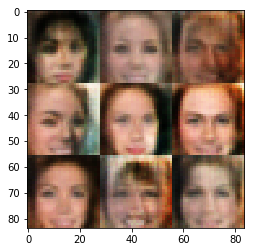

Step: 2210: Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 3.6594
Step: 2220: Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 2.1744
Step: 2230: Epoch 1/1... Discriminator Loss: 0.4104... Generator Loss: 3.1438
Step: 2240: Epoch 1/1... Discriminator Loss: 0.5059... Generator Loss: 4.0398
Step: 2250: Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 2.5986
Step: 2260: Epoch 1/1... Discriminator Loss: 0.4737... Generator Loss: 2.7988
Step: 2270: Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 3.2601
Step: 2280: Epoch 1/1... Discriminator Loss: 0.4447... Generator Loss: 3.3482
Step: 2290: Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 4.0706
Step: 2300: Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 2.2887


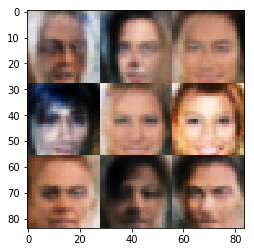

Step: 2310: Epoch 1/1... Discriminator Loss: 0.5852... Generator Loss: 1.8679
Step: 2320: Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 3.2268
Step: 2330: Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 4.6124
Step: 2340: Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 1.7032
Step: 2350: Epoch 1/1... Discriminator Loss: 0.4395... Generator Loss: 2.7353
Step: 2360: Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 1.1284
Step: 2370: Epoch 1/1... Discriminator Loss: 0.4705... Generator Loss: 3.0291
Step: 2380: Epoch 1/1... Discriminator Loss: 0.4535... Generator Loss: 3.3411
Step: 2390: Epoch 1/1... Discriminator Loss: 0.4771... Generator Loss: 3.1017
Step: 2400: Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 2.2342


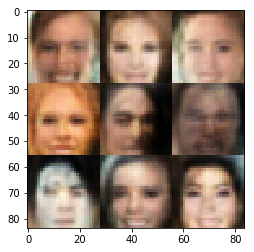

Step: 2410: Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 3.5725
Step: 2420: Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 4.2012
Step: 2430: Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 2.8319
Step: 2440: Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 2.6484
Step: 2450: Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 2.6041
Step: 2460: Epoch 1/1... Discriminator Loss: 0.4415... Generator Loss: 2.7589
Step: 2470: Epoch 1/1... Discriminator Loss: 0.4883... Generator Loss: 3.1674
Step: 2480: Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 1.9143
Step: 2490: Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 2.2248
Step: 2500: Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 3.9276


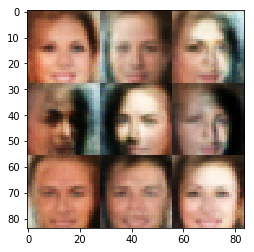

Step: 2510: Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 2.2327
Step: 2520: Epoch 1/1... Discriminator Loss: 0.6109... Generator Loss: 2.9461
Step: 2530: Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 5.0538
Step: 2540: Epoch 1/1... Discriminator Loss: 0.4694... Generator Loss: 2.7334
Step: 2550: Epoch 1/1... Discriminator Loss: 0.5189... Generator Loss: 2.3725
Step: 2560: Epoch 1/1... Discriminator Loss: 0.4592... Generator Loss: 2.8457
Step: 2570: Epoch 1/1... Discriminator Loss: 0.7245... Generator Loss: 1.5084
Step: 2580: Epoch 1/1... Discriminator Loss: 0.4621... Generator Loss: 2.1602
Step: 2590: Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 2.6015
Step: 2600: Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 2.5496


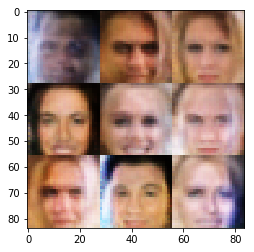

Step: 2610: Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 2.4957
Step: 2620: Epoch 1/1... Discriminator Loss: 0.5181... Generator Loss: 2.3034
Step: 2630: Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.3365
Step: 2640: Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 3.8685
Step: 2650: Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 3.9879
Step: 2660: Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 2.6350
Step: 2670: Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 3.2003
Step: 2680: Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 1.9831
Step: 2690: Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.7678
Step: 2700: Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 2.6442


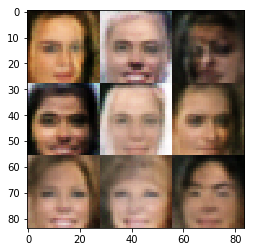

Step: 2710: Epoch 1/1... Discriminator Loss: 0.4626... Generator Loss: 2.8714
Step: 2720: Epoch 1/1... Discriminator Loss: 0.4728... Generator Loss: 3.5227
Step: 2730: Epoch 1/1... Discriminator Loss: 0.6256... Generator Loss: 4.1537
Step: 2740: Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 3.4227
Step: 2750: Epoch 1/1... Discriminator Loss: 0.5341... Generator Loss: 4.1491
Step: 2760: Epoch 1/1... Discriminator Loss: 0.5262... Generator Loss: 2.3913
Step: 2770: Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 2.5735
Step: 2780: Epoch 1/1... Discriminator Loss: 2.1267... Generator Loss: 5.7341
Step: 2790: Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 5.5314
Step: 2800: Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 2.3313


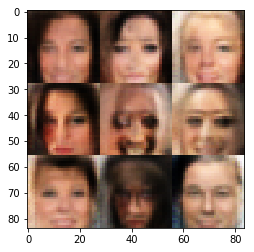

Step: 2810: Epoch 1/1... Discriminator Loss: 0.6598... Generator Loss: 1.6868
Step: 2820: Epoch 1/1... Discriminator Loss: 0.4075... Generator Loss: 2.9667
Step: 2830: Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 3.2307
Step: 2840: Epoch 1/1... Discriminator Loss: 0.4127... Generator Loss: 3.6886
Step: 2850: Epoch 1/1... Discriminator Loss: 0.6369... Generator Loss: 1.5714
Step: 2860: Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 2.3817
Step: 2870: Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 4.5495
Step: 2880: Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 2.8805
Step: 2890: Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 2.0090
Step: 2900: Epoch 1/1... Discriminator Loss: 0.4867... Generator Loss: 2.2718


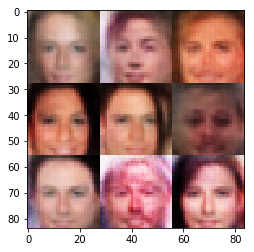

Step: 2910: Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 3.2596
Step: 2920: Epoch 1/1... Discriminator Loss: 0.5777... Generator Loss: 1.7786
Step: 2930: Epoch 1/1... Discriminator Loss: 0.5249... Generator Loss: 3.3587
Step: 2940: Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 1.4859
Step: 2950: Epoch 1/1... Discriminator Loss: 0.4584... Generator Loss: 3.0392
Step: 2960: Epoch 1/1... Discriminator Loss: 0.4405... Generator Loss: 2.9175
Step: 2970: Epoch 1/1... Discriminator Loss: 0.4499... Generator Loss: 2.5794
Step: 2980: Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 0.9544
Step: 2990: Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.4808
Step: 3000: Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 1.6490


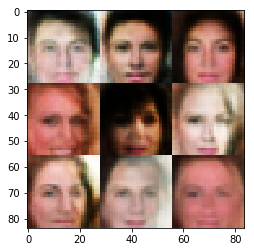

Step: 3010: Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.2848
Step: 3020: Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 3.3329
Step: 3030: Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 2.3256
Step: 3040: Epoch 1/1... Discriminator Loss: 1.9088... Generator Loss: 0.4813
Step: 3050: Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 1.7102
Step: 3060: Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 5.4840
Step: 3070: Epoch 1/1... Discriminator Loss: 0.6648... Generator Loss: 1.8220
Step: 3080: Epoch 1/1... Discriminator Loss: 0.8551... Generator Loss: 1.0960
Step: 3090: Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 2.2474
Step: 3100: Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.2196


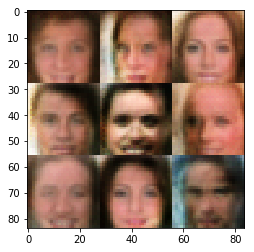

Step: 3110: Epoch 1/1... Discriminator Loss: 0.7289... Generator Loss: 1.7292
Step: 3120: Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 2.0876
Step: 3130: Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 3.3613
Step: 3140: Epoch 1/1... Discriminator Loss: 0.4589... Generator Loss: 2.5972
Step: 3150: Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 2.7897
Step: 3160: Epoch 1/1... Discriminator Loss: 0.5119... Generator Loss: 2.8551
Step: 3170: Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 3.3792
Step: 3180: Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 2.4759
Step: 3190: Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 1.7884
Step: 3200: Epoch 1/1... Discriminator Loss: 0.4332... Generator Loss: 2.4687


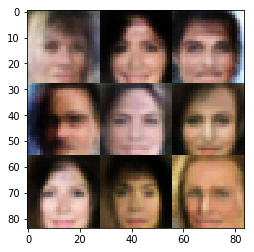

Step: 3210: Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 2.7387
Step: 3220: Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 3.3250
Step: 3230: Epoch 1/1... Discriminator Loss: 0.4496... Generator Loss: 2.3909
Step: 3240: Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 2.0735
Step: 3250: Epoch 1/1... Discriminator Loss: 0.4732... Generator Loss: 2.9914
Step: 3260: Epoch 1/1... Discriminator Loss: 0.4953... Generator Loss: 2.6384
Step: 3270: Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 2.6100
Step: 3280: Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 2.9059
Step: 3290: Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 4.1431
Step: 3300: Epoch 1/1... Discriminator Loss: 0.5397... Generator Loss: 1.9712


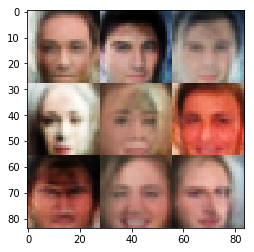

Step: 3310: Epoch 1/1... Discriminator Loss: 0.5699... Generator Loss: 3.1922
Step: 3320: Epoch 1/1... Discriminator Loss: 1.6379... Generator Loss: 6.3877
Step: 3330: Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.6165
Step: 3340: Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 1.9075
Step: 3350: Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.5429
Step: 3360: Epoch 1/1... Discriminator Loss: 0.4719... Generator Loss: 2.4689
Step: 3370: Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 2.3105
Step: 3380: Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 2.5717
Step: 3390: Epoch 1/1... Discriminator Loss: 0.4322... Generator Loss: 2.8783
Step: 3400: Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 2.4122


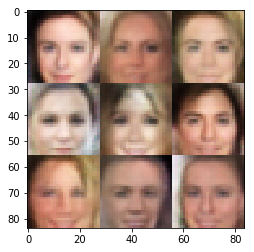

Step: 3410: Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.8345
Step: 3420: Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 1.8678
Step: 3430: Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.2674
Step: 3440: Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 2.6876
Step: 3450: Epoch 1/1... Discriminator Loss: 0.5244... Generator Loss: 2.2917
Step: 3460: Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 2.3192
Step: 3470: Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 3.0071
Step: 3480: Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 3.5362
Step: 3490: Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 3.0566
Step: 3500: Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 4.6424


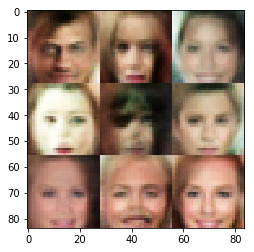

Step: 3510: Epoch 1/1... Discriminator Loss: 0.4623... Generator Loss: 2.8186
Step: 3520: Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 2.3520
Step: 3530: Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 3.9533
Step: 3540: Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 1.9748
Step: 3550: Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 1.7485
Step: 3560: Epoch 1/1... Discriminator Loss: 0.5140... Generator Loss: 2.5175
Step: 3570: Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 2.0348
Step: 3580: Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 3.4001
Step: 3590: Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 2.7418
Step: 3600: Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 2.0263


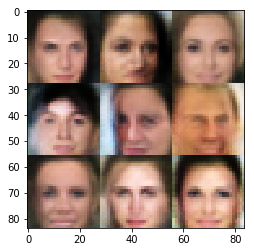

Step: 3610: Epoch 1/1... Discriminator Loss: 0.4527... Generator Loss: 2.9742
Step: 3620: Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.9676
Step: 3630: Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 2.1582
Step: 3640: Epoch 1/1... Discriminator Loss: 0.5951... Generator Loss: 1.9080
Step: 3650: Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 2.5630
Step: 3660: Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 2.0716
Step: 3670: Epoch 1/1... Discriminator Loss: 0.4514... Generator Loss: 3.3084
Step: 3680: Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 4.1015
Step: 3690: Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 2.1323
Step: 3700: Epoch 1/1... Discriminator Loss: 0.5524... Generator Loss: 2.0040


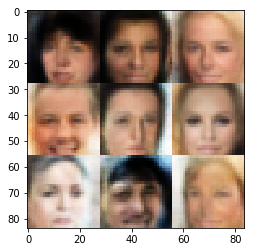

Step: 3710: Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.3643
Step: 3720: Epoch 1/1... Discriminator Loss: 0.4478... Generator Loss: 3.0635
Step: 3730: Epoch 1/1... Discriminator Loss: 0.5017... Generator Loss: 4.6829
Step: 3740: Epoch 1/1... Discriminator Loss: 0.5378... Generator Loss: 2.3730
Step: 3750: Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 4.2732
Step: 3760: Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 2.8777
Step: 3770: Epoch 1/1... Discriminator Loss: 0.4434... Generator Loss: 3.7895
Step: 3780: Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 4.4762
Step: 3790: Epoch 1/1... Discriminator Loss: 0.6587... Generator Loss: 2.0173
Step: 3800: Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.1846


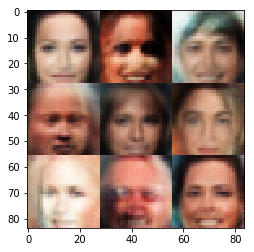

Step: 3810: Epoch 1/1... Discriminator Loss: 0.4352... Generator Loss: 3.0360
Step: 3820: Epoch 1/1... Discriminator Loss: 0.4773... Generator Loss: 2.6359
Step: 3830: Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 2.8404
Step: 3840: Epoch 1/1... Discriminator Loss: 0.4567... Generator Loss: 3.2829
Step: 3850: Epoch 1/1... Discriminator Loss: 0.6317... Generator Loss: 3.3560
Step: 3860: Epoch 1/1... Discriminator Loss: 0.4975... Generator Loss: 2.5688
Step: 3870: Epoch 1/1... Discriminator Loss: 0.5096... Generator Loss: 2.4536
Step: 3880: Epoch 1/1... Discriminator Loss: 0.6028... Generator Loss: 2.9681
Step: 3890: Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 2.3723
Step: 3900: Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 3.2126


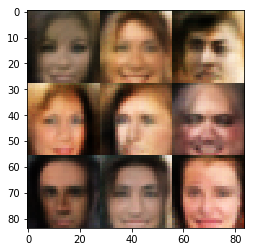

Step: 3910: Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 2.9086
Step: 3920: Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 4.7917
Step: 3930: Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 3.1900
Step: 3940: Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 2.2532
Step: 3950: Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 2.2934
Step: 3960: Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 3.0870
Step: 3970: Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 1.7255
Step: 3980: Epoch 1/1... Discriminator Loss: 0.4685... Generator Loss: 3.0957
Step: 3990: Epoch 1/1... Discriminator Loss: 0.5583... Generator Loss: 3.1666
Step: 4000: Epoch 1/1... Discriminator Loss: 0.6274... Generator Loss: 1.6604


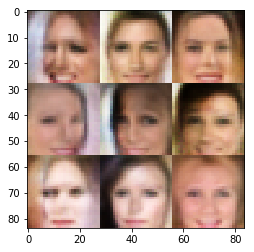

Step: 4010: Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 1.7540
Step: 4020: Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 1.7918
Step: 4030: Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 2.1630
Step: 4040: Epoch 1/1... Discriminator Loss: 0.5210... Generator Loss: 2.9129
Step: 4050: Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 2.7743
Step: 4060: Epoch 1/1... Discriminator Loss: 0.6103... Generator Loss: 2.0080
Step: 4070: Epoch 1/1... Discriminator Loss: 0.4312... Generator Loss: 2.8624
Step: 4080: Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 3.1410
Step: 4090: Epoch 1/1... Discriminator Loss: 0.5775... Generator Loss: 1.3798
Step: 4100: Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 2.9922


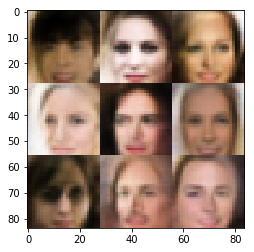

Step: 4110: Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 1.8298
Step: 4120: Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.3476
Step: 4130: Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 2.7328
Step: 4140: Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 3.1092
Step: 4150: Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 1.8983
Step: 4160: Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 1.5980
Step: 4170: Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 1.2311
Step: 4180: Epoch 1/1... Discriminator Loss: 0.5409... Generator Loss: 3.8418
Step: 4190: Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 2.8884
Step: 4200: Epoch 1/1... Discriminator Loss: 0.4556... Generator Loss: 2.5221


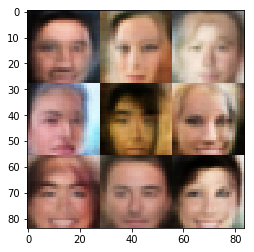

Step: 4210: Epoch 1/1... Discriminator Loss: 0.4195... Generator Loss: 2.9197
Step: 4220: Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.5944
Step: 4230: Epoch 1/1... Discriminator Loss: 0.5086... Generator Loss: 1.7363
Step: 4240: Epoch 1/1... Discriminator Loss: 0.5095... Generator Loss: 1.7798
Step: 4250: Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 3.8147
Step: 4260: Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 3.1306
Step: 4270: Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 2.9597
Step: 4280: Epoch 1/1... Discriminator Loss: 0.4796... Generator Loss: 2.3422
Step: 4290: Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 2.0580
Step: 4300: Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 2.5716


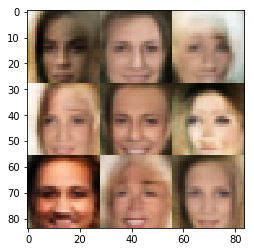

Step: 4310: Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 3.4298
Step: 4320: Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 2.6608
Step: 4330: Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.4067
Step: 4340: Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 4.1013
Step: 4350: Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 3.5581
Step: 4360: Epoch 1/1... Discriminator Loss: 0.4179... Generator Loss: 2.5096
Step: 4370: Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 2.3338
Step: 4380: Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 2.3668
Step: 4390: Epoch 1/1... Discriminator Loss: 0.4624... Generator Loss: 2.5367
Step: 4400: Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 5.4733


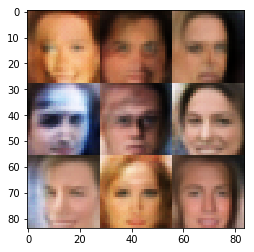

Step: 4410: Epoch 1/1... Discriminator Loss: 0.4696... Generator Loss: 2.5013
Step: 4420: Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 3.0732
Step: 4430: Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 1.9653
Step: 4440: Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 1.6883
Step: 4450: Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 1.3635
Step: 4460: Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.3991
Step: 4470: Epoch 1/1... Discriminator Loss: 0.5278... Generator Loss: 1.9810
Step: 4480: Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 1.9083
Step: 4490: Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 2.8864
Step: 4500: Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 2.5951


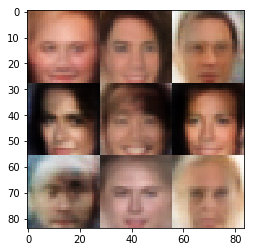

Step: 4510: Epoch 1/1... Discriminator Loss: 0.4130... Generator Loss: 2.6366
Step: 4520: Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 2.9157
Step: 4530: Epoch 1/1... Discriminator Loss: 0.6467... Generator Loss: 1.9708
Step: 4540: Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 1.6225
Step: 4550: Epoch 1/1... Discriminator Loss: 0.4508... Generator Loss: 2.1379
Step: 4560: Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 2.6850
Step: 4570: Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 1.9946
Step: 4580: Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 2.3478
Step: 4590: Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 1.5061
Step: 4600: Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 3.0308


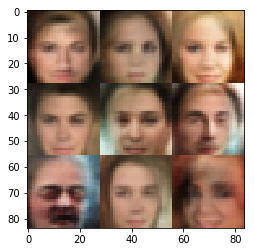

Step: 4610: Epoch 1/1... Discriminator Loss: 0.4555... Generator Loss: 2.2830
Step: 4620: Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 3.1571
Step: 4630: Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 1.6065
Step: 4640: Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 3.8713
Step: 4650: Epoch 1/1... Discriminator Loss: 0.4163... Generator Loss: 2.9621
Step: 4660: Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 1.3819
Step: 4670: Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 3.3613
Step: 4680: Epoch 1/1... Discriminator Loss: 0.4455... Generator Loss: 1.9223
Step: 4690: Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 1.9410
Step: 4700: Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 4.8212


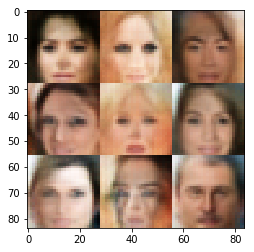

Step: 4710: Epoch 1/1... Discriminator Loss: 0.5524... Generator Loss: 2.1086
Step: 4720: Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 1.5662
Step: 4730: Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 3.5008
Step: 4740: Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 2.9801
Step: 4750: Epoch 1/1... Discriminator Loss: 0.5197... Generator Loss: 2.9271
Step: 4760: Epoch 1/1... Discriminator Loss: 0.5553... Generator Loss: 2.8187
Step: 4770: Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 2.0009
Step: 4780: Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 2.0873
Step: 4790: Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 1.9582
Step: 4800: Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 1.9974


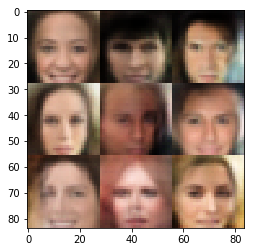

Step: 4810: Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 1.9853
Step: 4820: Epoch 1/1... Discriminator Loss: 0.4519... Generator Loss: 3.3171
Step: 4830: Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 2.0564
Step: 4840: Epoch 1/1... Discriminator Loss: 0.4237... Generator Loss: 3.9258
Step: 4850: Epoch 1/1... Discriminator Loss: 0.4208... Generator Loss: 3.1907
Step: 4860: Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.2483
Step: 4870: Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 1.8826
Step: 4880: Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.2199
Step: 4890: Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 2.2966
Step: 4900: Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 2.4757


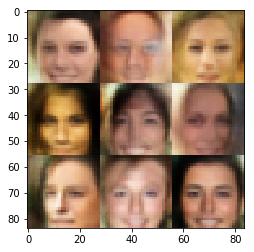

Step: 4910: Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 2.1164
Step: 4920: Epoch 1/1... Discriminator Loss: 0.4706... Generator Loss: 2.3690
Step: 4930: Epoch 1/1... Discriminator Loss: 0.4343... Generator Loss: 2.5194
Step: 4940: Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 4.1261
Step: 4950: Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 3.2821
Step: 4960: Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 2.7278
Step: 4970: Epoch 1/1... Discriminator Loss: 0.4198... Generator Loss: 2.2330
Step: 4980: Epoch 1/1... Discriminator Loss: 0.4543... Generator Loss: 2.9147
Step: 4990: Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 1.7526
Step: 5000: Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 2.4309


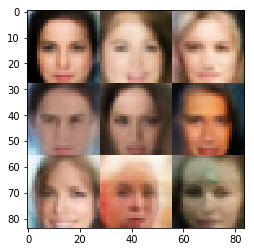

Step: 5010: Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.5603
Step: 5020: Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 2.5741
Step: 5030: Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 3.8980
Step: 5040: Epoch 1/1... Discriminator Loss: 0.4644... Generator Loss: 3.0358
Step: 5050: Epoch 1/1... Discriminator Loss: 0.4147... Generator Loss: 2.6220
Step: 5060: Epoch 1/1... Discriminator Loss: 3.8780... Generator Loss: 6.9554
Step: 5070: Epoch 1/1... Discriminator Loss: 0.5827... Generator Loss: 3.2254
Step: 5080: Epoch 1/1... Discriminator Loss: 0.5272... Generator Loss: 2.4452
Step: 5090: Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 3.5562
Step: 5100: Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 2.9007


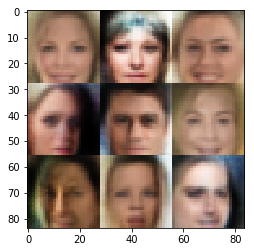

Step: 5110: Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 3.1463
Step: 5120: Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 3.5402
Step: 5130: Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 2.7523
Step: 5140: Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 1.6653
Step: 5150: Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 2.7177
Step: 5160: Epoch 1/1... Discriminator Loss: 0.4504... Generator Loss: 2.9342
Step: 5170: Epoch 1/1... Discriminator Loss: 0.4035... Generator Loss: 3.2423
Step: 5180: Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 3.1135
Step: 5190: Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 2.3746
Step: 5200: Epoch 1/1... Discriminator Loss: 0.4222... Generator Loss: 3.3703


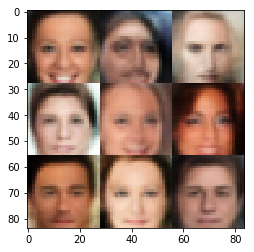

Step: 5210: Epoch 1/1... Discriminator Loss: 0.4482... Generator Loss: 3.3042
Step: 5220: Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 2.9421
Step: 5230: Epoch 1/1... Discriminator Loss: 0.4333... Generator Loss: 2.4842
Step: 5240: Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 2.1098
Step: 5250: Epoch 1/1... Discriminator Loss: 0.4170... Generator Loss: 4.0817
Step: 5260: Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 3.8313
Step: 5270: Epoch 1/1... Discriminator Loss: 0.4992... Generator Loss: 2.1541
Step: 5280: Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 3.6309
Step: 5290: Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 2.1229
Step: 5300: Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 1.8541


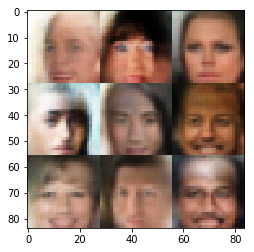

Step: 5310: Epoch 1/1... Discriminator Loss: 0.5408... Generator Loss: 1.8905
Step: 5320: Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 2.0965
Step: 5330: Epoch 1/1... Discriminator Loss: 0.4051... Generator Loss: 2.8506
Step: 5340: Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.1421
Step: 5350: Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 1.8525
Step: 5360: Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 2.3104
Step: 5370: Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 2.1450
Step: 5380: Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 3.2764
Step: 5390: Epoch 1/1... Discriminator Loss: 0.4574... Generator Loss: 3.1384
Step: 5400: Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 5.6388


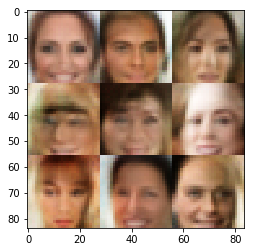

Step: 5410: Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.9852
Step: 5420: Epoch 1/1... Discriminator Loss: 0.4683... Generator Loss: 2.7503
Step: 5430: Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 2.9239
Step: 5440: Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 3.6258
Step: 5450: Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 3.2446
Step: 5460: Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 3.0957
Step: 5470: Epoch 1/1... Discriminator Loss: 0.5211... Generator Loss: 1.9802
Step: 5480: Epoch 1/1... Discriminator Loss: 0.4696... Generator Loss: 2.5451
Step: 5490: Epoch 1/1... Discriminator Loss: 0.7017... Generator Loss: 1.4711
Step: 5500: Epoch 1/1... Discriminator Loss: 0.4499... Generator Loss: 2.6109


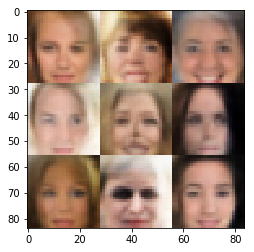

Step: 5510: Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 2.9876
Step: 5520: Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 2.2538
Step: 5530: Epoch 1/1... Discriminator Loss: 0.4306... Generator Loss: 3.0425
Step: 5540: Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 2.3625
Step: 5550: Epoch 1/1... Discriminator Loss: 0.4119... Generator Loss: 3.0052
Step: 5560: Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 2.1007
Step: 5570: Epoch 1/1... Discriminator Loss: 0.4320... Generator Loss: 2.9112
Step: 5580: Epoch 1/1... Discriminator Loss: 0.4157... Generator Loss: 3.5465
Step: 5590: Epoch 1/1... Discriminator Loss: 0.5188... Generator Loss: 2.9055
Step: 5600: Epoch 1/1... Discriminator Loss: 0.4502... Generator Loss: 2.8347


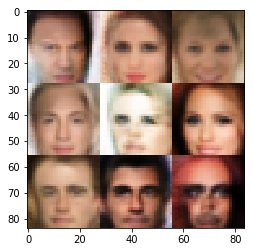

Step: 5610: Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 2.3079
Step: 5620: Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 1.6681
Step: 5630: Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.7082
Step: 5640: Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 2.8663
Step: 5650: Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 2.5089
Step: 5660: Epoch 1/1... Discriminator Loss: 1.6717... Generator Loss: 0.8095
Step: 5670: Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 2.4555
Step: 5680: Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.7154
Step: 5690: Epoch 1/1... Discriminator Loss: 0.4244... Generator Loss: 2.9929
Step: 5700: Epoch 1/1... Discriminator Loss: 0.4636... Generator Loss: 2.4635


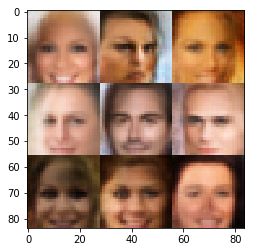

Step: 5710: Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 2.5846
Step: 5720: Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 2.9618
Step: 5730: Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 3.3421
Step: 5740: Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 1.9866
Step: 5750: Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 2.3374
Step: 5760: Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 2.6710
Step: 5770: Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 3.5376
Step: 5780: Epoch 1/1... Discriminator Loss: 0.4779... Generator Loss: 2.3965
Step: 5790: Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.2807
Step: 5800: Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 2.1347


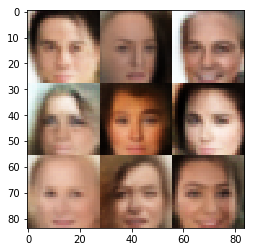

Step: 5810: Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.3073
Step: 5820: Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 2.0296
Step: 5830: Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.3394
Step: 5840: Epoch 1/1... Discriminator Loss: 0.5553... Generator Loss: 3.9451
Step: 5850: Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 3.7279
Step: 5860: Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 1.8628
Step: 5870: Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 3.0987
Step: 5880: Epoch 1/1... Discriminator Loss: 0.3859... Generator Loss: 2.9148
Step: 5890: Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 2.6409
Step: 5900: Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 2.2325


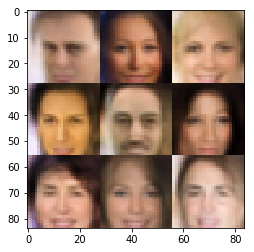

Step: 5910: Epoch 1/1... Discriminator Loss: 0.4691... Generator Loss: 2.7592
Step: 5920: Epoch 1/1... Discriminator Loss: 0.4254... Generator Loss: 2.6362
Step: 5930: Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 2.1334
Step: 5940: Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 3.2896
Step: 5950: Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 1.0169
Step: 5960: Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.4149
Step: 5970: Epoch 1/1... Discriminator Loss: 0.5268... Generator Loss: 1.9566
Step: 5980: Epoch 1/1... Discriminator Loss: 0.5211... Generator Loss: 3.3705
Step: 5990: Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 2.3721
Step: 6000: Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 1.3914


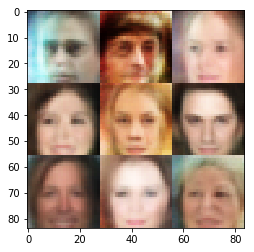

Step: 6010: Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 2.7508
Step: 6020: Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 2.7043
Step: 6030: Epoch 1/1... Discriminator Loss: 0.4564... Generator Loss: 3.4327
Step: 6040: Epoch 1/1... Discriminator Loss: 0.4346... Generator Loss: 2.9392
Step: 6050: Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 2.3231
Step: 6060: Epoch 1/1... Discriminator Loss: 0.5402... Generator Loss: 3.4887
Step: 6070: Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 2.9697
Step: 6080: Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 3.0703
Step: 6090: Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 2.5382
Step: 6100: Epoch 1/1... Discriminator Loss: 0.4373... Generator Loss: 2.1710


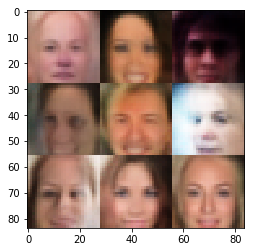

Step: 6110: Epoch 1/1... Discriminator Loss: 0.4823... Generator Loss: 2.0945
Step: 6120: Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 3.0619
Step: 6130: Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 2.7584
Step: 6140: Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 2.7673
Step: 6150: Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 1.6038
Step: 6160: Epoch 1/1... Discriminator Loss: 0.4447... Generator Loss: 2.2524
Step: 6170: Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 1.9715
Step: 6180: Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 3.3037
Step: 6190: Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 2.8951
Step: 6200: Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 1.3972


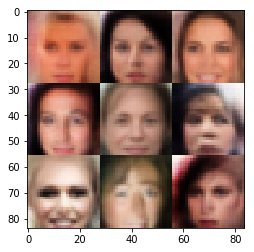

Step: 6210: Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 2.7244
Step: 6220: Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.7301
Step: 6230: Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 2.3613
Step: 6240: Epoch 1/1... Discriminator Loss: 0.3943... Generator Loss: 3.4229
Step: 6250: Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 2.7240
Step: 6260: Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 3.2955
Step: 6270: Epoch 1/1... Discriminator Loss: 0.4328... Generator Loss: 2.8298
Step: 6280: Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 2.3570
Step: 6290: Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 2.3337
Step: 6300: Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 3.2120


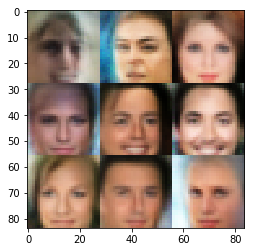

Step: 6310: Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.6347
Step: 6320: Epoch 1/1... Discriminator Loss: 0.6438... Generator Loss: 1.9631
Step: 6330: Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.7326
Training done!


In [34]:
batch_size = 32
z_dim = 128
learning_rate = 0.00015
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.